# A/B-тестирование - recommender_system_test

**Описание проекта**

Предстоит провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Цель проекта**

1. Оценить корректность проведения теста `recommender_system_test`
2. Проанализировать результаты теста

# Структура A/B тестирования

1. Чтение и предобработка данных
2. Оценить корректность проведения теста. Обратить внимание на:
    - Соответствие данных требованиям технического задания. Проверить корректность всех пунктов технического задания.
    - Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверить равномерность распределения по тестовым группам и правильность их формирования.
3. Провести исследовательский анализ данных (EDA):
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
4. Оценить результаты A/B-тестирования
    - Что можно сказать про результаты A/В-тестирования?
    - Проверить статистическую разницу долей z-критерием.
5. Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Оглавление:**
<a id='section_id'></a>

1. [Импорт библиотек и загрузка данных](#section_id1)
2. [Корректность проведения теста](#section_id2)
3. [Исследовательский анализ данных (EDA)](#section_id3)
4. [Результаты A/B-тестирования](#section_id4)
5. [Результаты исследования](#section_id5)

## Импорт библиотек и загрузка данных
<a id='section_id1'></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import datetime as dt

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

from IPython.display import display, HTML
import warnings

In [2]:
# Формат отображения данных - отображение всех колонок и ограничиваю количество знаков после запятой
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 50
# формат отображения ячеек с кодом:
display(HTML("<style>.container{width:80% !important;}</style"))

# форматирую вывод графиков
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [3]:
final_ab_events, ab_project_marketing_events, final_ab_new_users, final_ab_participants = (
    pd.read_csv('/datasets/final_ab_events.csv')
    ,pd.read_csv('/datasets/ab_project_marketing_events.csv')
    ,pd.read_csv('/datasets/final_ab_new_users.csv')
    ,pd.read_csv('/datasets/final_ab_participants.csv')
)

### Обзор данных

#### `final_ab_events`

In [4]:
display(final_ab_events.head(3))
display(final_ab_events.info())
display(final_ab_events.describe())

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,details
count,"62,740.00"
mean,23.88
std,72.18
min,4.99
25%,4.99
50%,4.99
75%,9.99
max,499.99


#### `ab_project_marketing_events`

In [5]:
display(ab_project_marketing_events)
display(ab_project_marketing_events.info())
display(ab_project_marketing_events.describe())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


#### `final_ab_new_users`

In [6]:
display(final_ab_new_users.head(3))
display(final_ab_new_users.info())
display(final_ab_new_users.describe())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


#### `final_ab_participants`

In [7]:
display(final_ab_participants.head(3))
display(final_ab_participants.info())
display(final_ab_participants.describe())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


При первичном обзоре данных выявлены следующие проблемы:
- приведу значения во всех датасетах к нижнему регистру
- во всех датасетах, где есть дата, необходимо изменить тип данных на `datetime`
- в датасете `final_ab_events` выявлены пропуски - при предобработке посмотрю как их исправить
- проверю данные на явные дубликаты
- в датасете `final_ab_participants` указаны данные двух разных тестов, при проверке на соответствие требованиям ТЗ уберу данные, не относящиеся к текущему исследованию.


### Предобработка данных

**Приведение к нижнему регистру**

In [8]:
final_ab_events['user_id'] = final_ab_events['user_id'].str.lower()
final_ab_events['event_name'] = final_ab_events['event_name'].str.lower()

ab_project_marketing_events['name'] = ab_project_marketing_events['name'].str.lower()
ab_project_marketing_events['regions'] = ab_project_marketing_events['regions'].str.lower()

final_ab_new_users['user_id'] = final_ab_new_users['user_id'].str.lower()
final_ab_new_users['region'] = final_ab_new_users['region'].str.lower()
final_ab_new_users['device'] = final_ab_new_users['device'].str.lower()

final_ab_participants['user_id'] = final_ab_participants['user_id'].str.lower()
final_ab_participants['group'] = final_ab_participants['group'].str.lower()

**Изменение типов данных**

In [9]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt']).dt.round('1S')

ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt']).dt.round('1d')
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt']).dt.round('1d')

final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date']).dt.round('1d')

**Анализ пропусков в датасете final_ab_events**

Сгруппирую датафрейм по виду событий и выведу колонку `details`

In [10]:
final_ab_events.groupby('event_name').agg(details_count=('details', 'count')).reset_index()

,event_name,details_count
0,login,0
1,product_cart,0
2,product_page,0
3,purchase,62740


Пропуски в датасете `final_ab_events` в колонке `details` относятся к тем строкам, где нет доп деталей по событию - вход, просмотр корзины. Проверю, встречается ли в колонке `details` начение 0, если нет, то заменю все пропуски на нули для дальнейшей работы со столбцом.

In [11]:
final_ab_events['details'] = final_ab_events['details'].fillna(0)

# Проверю корректность замены
final_ab_events.pivot_table(index='event_name', values='details', aggfunc='count')

,details
event_name,
login,189552
product_cart,62462
product_page,125563
purchase,62740


Пропуски заменены на 0


**Проверка на явные дубликаты**

In [12]:
print('Количество явных дубликатов в final_ab_events:', final_ab_events.duplicated().sum())
print('Количество явных дубликатов в ab_project_marketing_events:', ab_project_marketing_events.duplicated().sum())
print('Количество явных дубликатов в final_ab_new_users:', final_ab_new_users.duplicated().sum())
print('Количество явных дубликатов в final_ab_participants:', final_ab_participants.duplicated().sum())

Количество явных дубликатов в final_ab_events: 0
Количество явных дубликатов в ab_project_marketing_events: 0
Количество явных дубликатов в final_ab_new_users: 0
Количество явных дубликатов в final_ab_participants: 0


Пользователи с датой регистрации позже 21.12 относятся к другому тестированию.

**Вывод:**

- Все буквенные значения в датасетах приведены к нижнему регистру.
- Данные приведены к нужному типу
- Явные дубликаты не обнаружены
- Пропуски в `final_ab_events` проанализирваны, замены на нули.

[Оглавление](#section_id)

## Корректность проведения теста
<a id='section_id2'></a>

### Соответствие данных требованиям технического задания.

Необходимо проверить корректность всех пунктов технического задания.

#### Название теста

Recommender_system_test

На этапе обзора днных было выявлено, что в датасете присутствуют данные относящиеся к другому тестированию.

In [13]:
final_ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [14]:
# Оставлю в датафрейме только те данные, которые относятся к текущему тесту:
final_ab_participants_clear = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']\
                                            .reset_index(drop=True)
final_ab_participants_clear[['ab_test']].describe()

,ab_test
count,6701
unique,1
top,recommender_system_test
freq,6701


#### Группы тестирования

А — контрольная, B — новая платёжная воронка

In [15]:
# Проверю названия групп:
final_ab_participants['group'].unique()

array(['a', 'b'], dtype=object)

Названия групп соответствуют ТЗ.

#### Дата остановки набора новых пользователей, дата запуска и остановки тестирования

- дата остановки набора новых пользователей: 2020-12-21
- дата запуска: 2020-12-07
- дата остановки: 2021-01-04

In [16]:
# Дата остановки набора новых пользователей
print('Первоначальная максимальная дата регистрации новых пользователей:', final_ab_new_users['first_date'].max())

final_ab_new_users = final_ab_new_users.loc[final_ab_new_users['first_date'] <= '2020-12-21'].reset_index(drop=True)
print('Корректная максимальная дата регистрации новых пользователей:', final_ab_new_users['first_date'].max())

# Даты запуска и остановки тестирования
final_ab_events.agg({'event_dt':['min', 'max']})

Первоначальная максимальная дата регистрации новых пользователей: 2020-12-23 00:00:00
Корректная максимальная дата регистрации новых пользователей: 2020-12-21 00:00:00


,event_dt
min,2020-12-07 00:00:33
max,2020-12-30 23:36:33


Дата завершения тестирования отличается от требования в ТЗ. События, происходившие с 23:36:33 30 декабря до 4 января не попали в датасет.

Дата 4 января была выбрана исходя двухнедельного горизонта анализа (регистрация пользователй заканчивалась 21 декабря). Но данные зашли за период короче на 5 дней. Таким образом, мы не досчитаемся событий пользователей при проверке улучшения конверсии - в анализ не попадут события тех кто присоединился позже 16 декабря.

#### Аудитория

15% новых пользователей из региона EU

Для проверки данного пункта ТЗ, объединю 2 датафрейма с пользователями в один. 

In [17]:
final_ab_users = final_ab_participants_clear.merge(final_ab_new_users, on='user_id', how='left')

# Выведу полученный датафрейм
final_ab_users.head(3)

,user_id,group,ab_test,first_date,region,device
0,d1aba3e2887b6a73,a,recommender_system_test,2020-12-07,eu,pc
1,a7a3664bd6242119,a,recommender_system_test,2020-12-20,eu,iphone
2,dabc14fddfadd29e,a,recommender_system_test,2020-12-08,eu,mac


In [18]:
# Распределение пользователей по регионам
final_ab_users['region'].value_counts()

eu           6351
n.america     223
apac           72
cis            55
Name: region, dtype: int64

Согласно ТЗ, аудитирия для теста должна состоять на 15% от всех новых пользователей из Европы, оставлю в датасете только пользователей из eu.

In [19]:
final_ab_users = final_ab_users.loc[final_ab_users['region'] == 'eu'].reset_index(drop=True)

print('Доля пользователей из Европы относительно всех пользователей: {:.1%}'.\
      format(final_ab_users['user_id'].nunique() / 
       final_ab_new_users[final_ab_new_users['region'] == 'eu']['user_id'].nunique()))

Доля пользователей из Европы относительно всех пользователей: 15.0%


В тесте участвуют ровно 15% от всех пользователей из Европы

**Формирование единого датафрейма**

Для дальнейшего анализа добавлю к объединённому датафрейму данные из `final_ab_events` методом `left`

In [20]:
final_ab = final_ab_users.merge(final_ab_events, on='user_id', how='left')

# Поменяю местами столбцы для удобства
final_ab = final_ab[['user_id', 'group', 'ab_test', 'region', 'device', 'event_name', 'details', 'first_date', 'event_dt']]

# Выведу полученный датафрейм
final_ab.head(3)

,user_id,group,ab_test,region,device,event_name,details,first_date,event_dt
0,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,purchase,99.99,2020-12-07,2020-12-07 14:43:27
1,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,purchase,4.99,2020-12-07,2020-12-25 00:04:56
2,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,product_cart,0.00,2020-12-07,2020-12-07 14:43:29


In [21]:
final_ab.info()
print('')
print('Количество уникальных пользователей:', final_ab['user_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   ab_test     26290 non-null  object        
 3   region      26290 non-null  object        
 4   device      26290 non-null  object        
 5   event_name  23420 non-null  object        
 6   details     23420 non-null  float64       
 7   first_date  26290 non-null  datetime64[ns]
 8   event_dt    23420 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 2.0+ MB

Количество уникальных пользователей: 6351


После объединения датасетов образовались пустые значения, подтянутые из датафрейма `final_ab_events`. Эти пропуски относятся к пользователям, не совершивших ни одного действия после регистрации. Сохраню этих пользователей в отдельный датафрейм, а из основного удалю пропуски, оставив только пользователей, совершивших какое-либо действие.

In [22]:
users_no_events = final_ab[final_ab['event_name'].isna()]
# Убираю неактивных пользователей (строки с пропусками в названии события)
final_ab.dropna(subset=['event_name'], inplace=True)
final_ab = final_ab.reset_index(drop=True)
# Проверка датафрейма
final_ab.info()
print('')
print('Количество уникальных пользователей (без действий):', users_no_events['user_id'].nunique())
print('Количество уникальных пользователей (совершивших действие):', final_ab['user_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23420 entries, 0 to 23419
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23420 non-null  object        
 1   group       23420 non-null  object        
 2   ab_test     23420 non-null  object        
 3   region      23420 non-null  object        
 4   device      23420 non-null  object        
 5   event_name  23420 non-null  object        
 6   details     23420 non-null  float64       
 7   first_date  23420 non-null  datetime64[ns]
 8   event_dt    23420 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB

Количество уникальных пользователей (без действий): 2870
Количество уникальных пользователей (совершивших действие): 3481


#### Назначение теста 

Тестирование изменений, связанных с внедрением улучшенной рекомендательной системы - данный пункт проверен при фильтрации датафрейма `final_ab_participants` по названию тестирования. Данные пользователей, относящиеся к другому тестированию, исключены из датафреймов. 


#### Ожидаемое количество участников теста

Ожидаемое число участников = 6000

In [23]:
print('Число пользователей:', final_ab_users['user_id'].nunique())
print('Число пользователей, совершивших действие:', final_ab['user_id'].nunique())

Число пользователей: 6351
Число пользователей, совершивших действие: 3481


Число пользователей, совершивший хоть одно действие почти в 2 раза ниже заявленного требования.

#### Метрики - ожидаемый эффект

Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие `product_page`,
- просмотры корзины — `product_cart`,
- покупки — `purchase`.


По ТЗ нам нужно проанализировать период с момента регистрации в 14 дней, расчитаю лайфтайм между датами регистрации и события и уберу из датафрейма события, превышающие лайфтайм в 14 дней.  

In [24]:
# Добавление колонки lifetime
final_ab['lifetime'] = (final_ab['event_dt'] - final_ab['first_date']).dt.days
print('Величина датафрейма до исключения событий с lifetime > 14 дней:', final_ab.shape)

Величина датафрейма до исключения событий с lifetime > 14 дней: (23420, 10)


In [25]:
# Уберу строки с lifetime > 14 ней
final_ab = final_ab[final_ab['lifetime'] <= 14].reset_index(drop=True)

print('Величина датафрейма после исключения событий с lifetime > 14 дней:', final_ab.shape)
display(final_ab.head(3))

Величина датафрейма после исключения событий с lifetime > 14 дней: (22828, 10)


,user_id,group,ab_test,region,device,event_name,details,first_date,event_dt,lifetime
0,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,purchase,99.99,2020-12-07,2020-12-07 14:43:27,0
1,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,product_cart,0.00,2020-12-07,2020-12-07 14:43:29,0
2,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,product_page,0.00,2020-12-07,2020-12-07 14:43:27,0


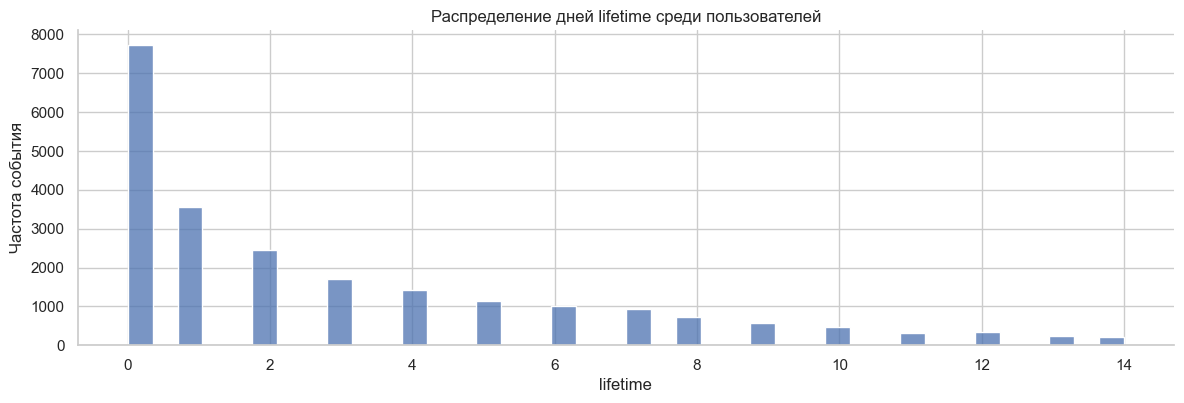

In [26]:
# Количество событий распределеннных в зависимости от лайфтайма пользователя
sns.displot(final_ab, x="lifetime", height=4, aspect=3)

plt.title('Распределение дней lifetime среди пользователей')
plt.ylabel('Частота события')
plt.show()

In [27]:
# Построю сводную таблицу с количеством пользователей для каждого события двух тестовых групп
final_event_pvt = final_ab.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()

# вычисление конверсии для группы А и В и расчет разницы конверсий группы В относительно А
final_event_pvt['conversion_a'] = final_event_pvt['a'] / final_ab[final_ab['group']=='a']['user_id'].nunique() * 100
final_event_pvt['conversion_b'] = final_event_pvt['b'] / final_ab[final_ab['group']=='b']['user_id'].nunique() * 100

final_event_pvt['difference'] = final_event_pvt['conversion_b'] - final_event_pvt['conversion_a']

# сортировка строк в соответствии с воронкой
final_event_pvt = final_event_pvt.reindex([0, 2, 1, 3]).reset_index(drop=True)

final_event_pvt

group,event_name,a,b,conversion_a,conversion_b,difference
0,login,2604,876,100.00,99.89,-0.11
1,product_page,1685,493,64.71,56.21,-8.49
2,product_cart,782,244,30.03,27.82,-2.21
3,purchase,833,249,31.99,28.39,-3.60


Отрицательные значения говорят, что метрики не только не улучшились на ожидаемые 10%, но и ухудшились.

### Время проведения теста

Необходимо убедиться, что оно не совпадает с маркетинговыми и другими активностями. Отберу маркетинговые кампании, которые пересекаются со временем проведения тестирования.

In [28]:
# маркетинговые компании, которые могут повлиять на тест
ab_project_marketing_events[(ab_project_marketing_events['start_dt'] <= '2020-01-04')
                           | (ab_project_marketing_events['finish_dt'] >= '2020-12-07')]

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
10,cis new year gift lottery,cis,2020-12-30,2021-01-07


Время проведения кампаний `christmas&new year promo` совпадает со временем проведения теста, начиная с 25 декабря. Чтобы не получить ложные результаты, проверю распределение событий в двух группах, начиная с 25 числа. Если не будет перекоса в какой-либо из групп, значит данная компания одинаковая влияла на обе группы и нет необходимости исключать события из анализа.

`cis new year gift lottery` тоже захватывает период тестирования, но эта компания проводится для региона cis, а у нас пользователи только из eu, поэтому на их поведении эта кампания не скажется.

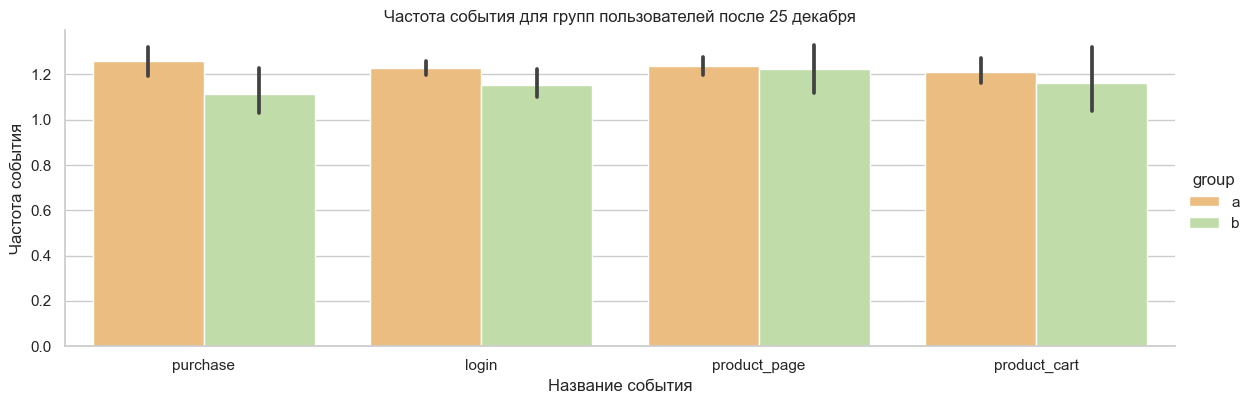

In [29]:
# Подсчёт количества вида события для пользователя в разных группах после 25 декабря
final_ab_users_count_25 = (final_ab[final_ab['event_dt'] >= '2020-12-25']
                        .groupby(['user_id', 'group', 'event_name'])
                        .agg(events_count=('event_name', 'count')).sort_values(by='group').reset_index())

# Количество каждого события для пользователей разных групп после 25 декабря
sns.catplot(data=final_ab_users_count_25, x='event_name', y='events_count', 
            hue='group', kind='bar', palette='Spectral', height=4, aspect=3)
plt.title('Частота события для групп пользователей после 25 декабря')
plt.xlabel('Название события')
plt.ylabel('Частота события')
plt.show()

Из распределения частоты событий нельзя сделать вывод, что маркетинговая кампания повлияла на какую-то из групп больше, чем на другую. Не буду исключать данные по событиям после 25 декабря из дальнейшего анализа.

### Аудитория теста 

Удостовериться, что:
- нет пересечений с конкурирующим тестом,
- нет пользователей, участвующих в двух группах теста одновременно
- проверить равномерность распределения по тестовым группам и правильность их формирования.


#### Пересечение пользователей с конкурирующим тестом

In [30]:
# подсчет количества пересекающихся между тестами пользователей
test_1_users = final_ab_participants.loc[final_ab_participants['ab_test']=='recommender_system_test', 'user_id']
test_2_users = final_ab_participants.loc[final_ab_participants['ab_test']=='interface_eu_test', 'user_id']

# датафрейм с пользователями в двух тестах:
users_1_2 = final_ab_participants.loc[
    (final_ab_participants['user_id'].isin(test_1_users)) & (final_ab_participants['user_id'].isin(test_2_users))
]

print('Количество пересекающихся пользователей:', users_1_2['user_id'].nunique())
users_1_2.sort_values('user_id').head(4)

Количество пересекающихся пользователей: 1602


,user_id,group,ab_test
17892,001064feaab631a1,b,interface_eu_test
235,001064feaab631a1,b,recommender_system_test
16961,00341d8401f0f665,a,interface_eu_test
2137,00341d8401f0f665,a,recommender_system_test


1 602 пользователя участвовали в двух тестах. Данных и ТЗ о втором тесте у нас нет, поэтому нельзя сказать точно могли (и если да, то каким образом) или нет пересекающиеся пользователи повлиять на результаты нашего тестирования. Тем не менее, второй тест мог повлиять на результат нашего теста, если распределение пользователей, которые участвовали в группе В второго теста не было равномерным между пользователями группы А и В первого теста.

Отберу пользователей группы B второго теста и посмотрю как они распределяются между группами А и В исследуемого теста.

In [31]:
users_test2_b = users_1_2[(users_1_2['ab_test'] == 'interface_eu_test') & (users_1_2['group'] == 'b')]['user_id']

# Построю распределение пользователей нашего теста 1 между группами А и B:
(final_ab_participants[final_ab_participants['user_id'].isin(users_test2_b) 
                      & (final_ab_participants['ab_test'] == 'recommender_system_test')]
        .groupby('group')['user_id'].nunique())

group
a    439
b    344
Name: user_id, dtype: int64

Пользователи из второго теста `interface_eu_test` группы B относительно равномерно распределены между пользователями групп A и B исследуемого теста `recommender_system_test`. Таким образом, не буду удалять пользователей, попавших в оба тестирования. 

#### Пользователи, попавшие в обе группы

In [32]:
group_a_users = final_ab[final_ab['group']=='a']
group_b_users = final_ab[final_ab['group']=='b']

# Отфильтрую датафрейм по пользователям, которые находятся в обеих группах:
final_ab.loc[(final_ab['user_id'].isin(group_a_users)) & (final_ab['user_id'].isin(group_b_users))]

,user_id,group,ab_test,region,device,event_name,details,first_date,event_dt,lifetime


#### Распределение пользователей по тестовым группам

In [33]:
final_ab.groupby('group')['user_id'].nunique()

group
a    2604
b     877
Name: user_id, dtype: int64

Среди пользователей деление на группы неравномерное, посмотрю более детально на регистрацию пользователей в разрезе групп по датам - построю гистограмму в разрезе пользователей по группам и по датам.

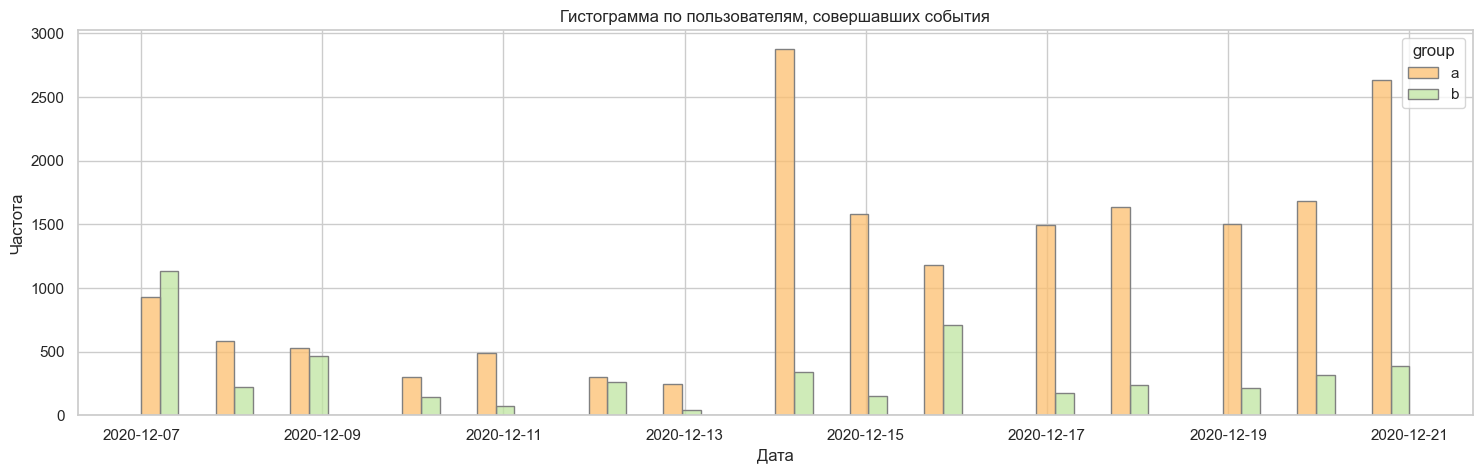

In [34]:
plt.figure(figsize=(18, 5))
sns.histplot(final_ab, x='first_date', hue='group', multiple='dodge', palette='Spectral', edgecolor='0.5')
plt.title('Гистограмма по пользователям, совершавших события')
plt.xlabel('Дата')
plt.ylabel('Частота')

plt.show()

Количество регистраций пользователей группы А резко растёт в тот день, когда пропали пользователи без событий. По какой-то причине они  резко начали пользоваться продуктом. 
- Возможно, для группы А исправили какую-то проблему, начиная с 14 числа, а для группы В нет.
- Так же отмечу, что число регистраций пользователей группы А, совершавших события до 14 числа находилось в диапазоне 250-1000 чел, а аналогичное число пользователей без событий в диапазоне 50-250 чел. Суммарное число в районе 1000 человек, но начиная с 14 декабря число регистраций юзеров группы А резко вырастает до 3000 чел и далее находится в диапазоне 1500-2500 чел., что выше значений до 14 декабря.

In [35]:
# Распределение пользователей без действий по группам
users_no_events['group'].value_counts()

b    1840
a    1030
Name: group, dtype: int64

Среди пользователей без совершённых событий деление на группы неравномерное, аналогично пользователям с действиями. Построю гистограмму.

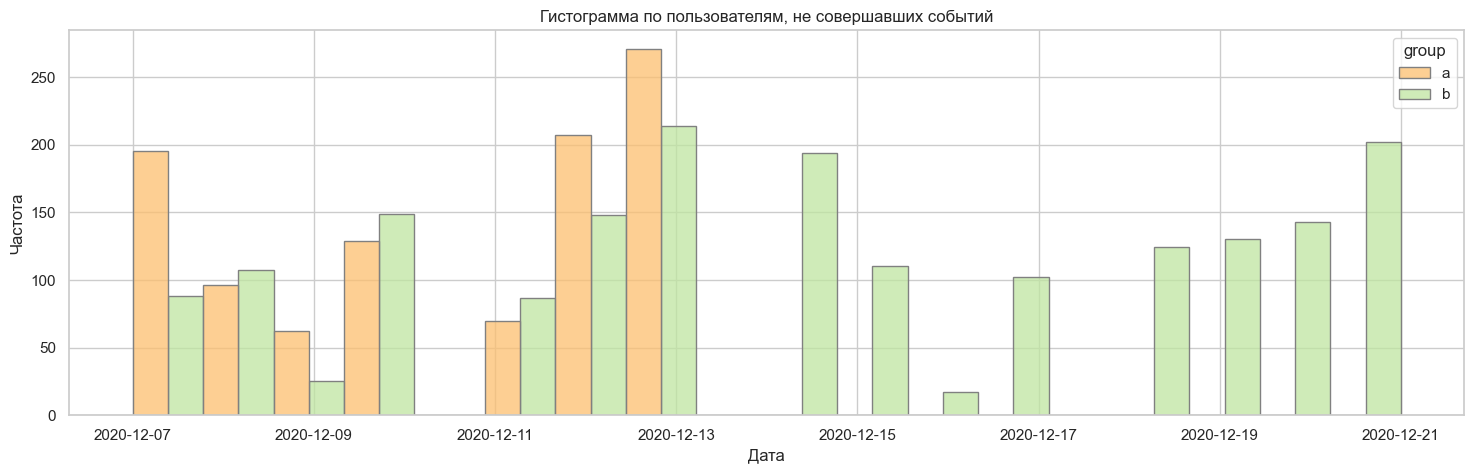

In [36]:
plt.figure(figsize=(18, 5))
sns.histplot(users_no_events.sort_values(by='group'), x='first_date', 
             hue='group', multiple='dodge', palette='Spectral', edgecolor='0.5')

plt.title('Гистограмма по пользователям, не совершавших событий')
plt.xlabel('Дата')
plt.ylabel('Частота')

plt.show()

После 13 декабря все пользователи, попавшие в группу А совершали какие-либо события, а для группы В осталась тенденция к присоединению пользователей без событий, отсюда возникает разница в 800 человек. Что-то произошло после 13 декабря.

Дополнительно посмотрю на пользователей группы B (так как проблема отсутствия событий для группы А решилась с середины декабря) без событий в разрезе устройств.

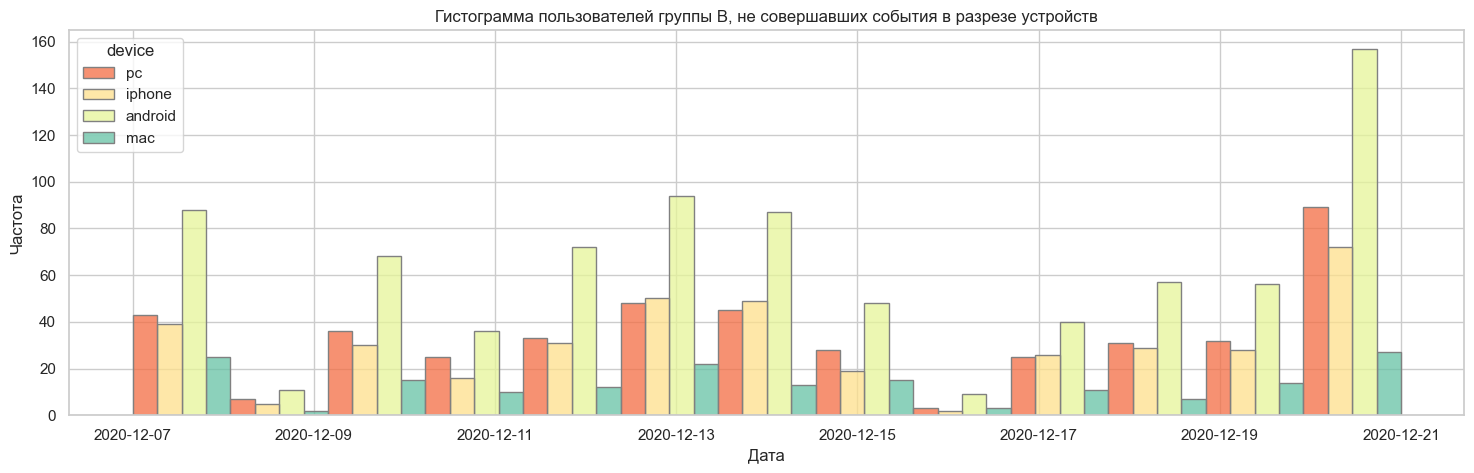

In [37]:
plt.figure(figsize=(18, 5))
sns.histplot(users_no_events[users_no_events['group']=='b'], x='first_date', hue='device', 
             multiple='dodge', palette='Spectral', edgecolor='0.5')
plt.title('Гистограмма пользователей группы B, не совершавших события в разрезе устройств')
plt.xlabel('Дата')
plt.ylabel('Частота')

plt.show()

На графике влияние вида устройства на совершение событий не выявлено.

**Вывод - Корректность проведения тестирования:**

1. Данные проверены на соответствие ТЗ. Выявлены отклонения от требований:
- дата остановки тестирования, ожидаемая - 04.01, фактическая - 30.12
- число пользователей ниже ожидаемых 6 000 - по факту число активных пользователей 3 481
- пользователи за 14 дней с момента регистрации не показали улучшение конверсий в события на 10%, наоборот наблюдается ухудшение эти показателей.
2. Время тестирования приходится на маркетинговую рождественскую кампанию, однако по результатам анализа, влияния на действия пользователей двух групп не выявлено.
3. Присутствуют большое число пользователей (1 602 чел.), участвующих в двух тестах одновременно, ТЗ на второй тест мы не знаем и нет возможности полностью установить влияние второго теста на наше исследование.

[Оглавление](#section_id)

## Исследовательский анализ данных (EDA)
<a id='section_id3'></a>

### Распределение количества событий на пользователя

Количество событий на пользователя одинаково распределены в выборках?

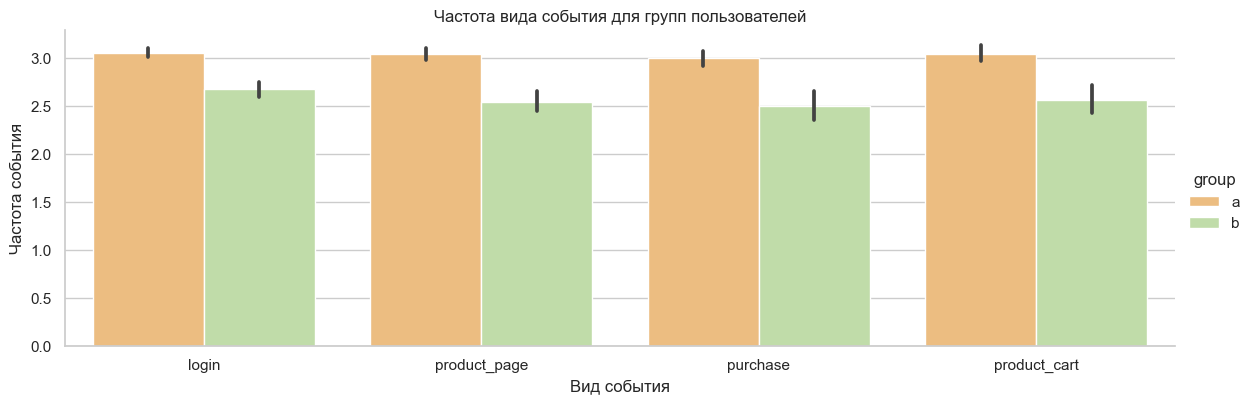

In [38]:
group_user_event_grp = (final_ab.groupby(['group', 'user_id', 'event_name'])
                        .agg(events_count=('event_name', 'count')).reset_index())
# Количество каждого события для пользователей разных групп
sns.catplot(data=group_user_event_grp, x='event_name', y='events_count', 
            kind='bar', hue='group', palette='Spectral', height=4, aspect=3)

plt.title('Частота вида события для групп пользователей')
plt.xlabel('Вид события')
plt.ylabel('Частота события')
plt.show()

Пользователи в группах А и В совершают примерно равное количество каждого вида события.

Посмотрю распределение количества пользовательских событий в разрезе групп A и B.

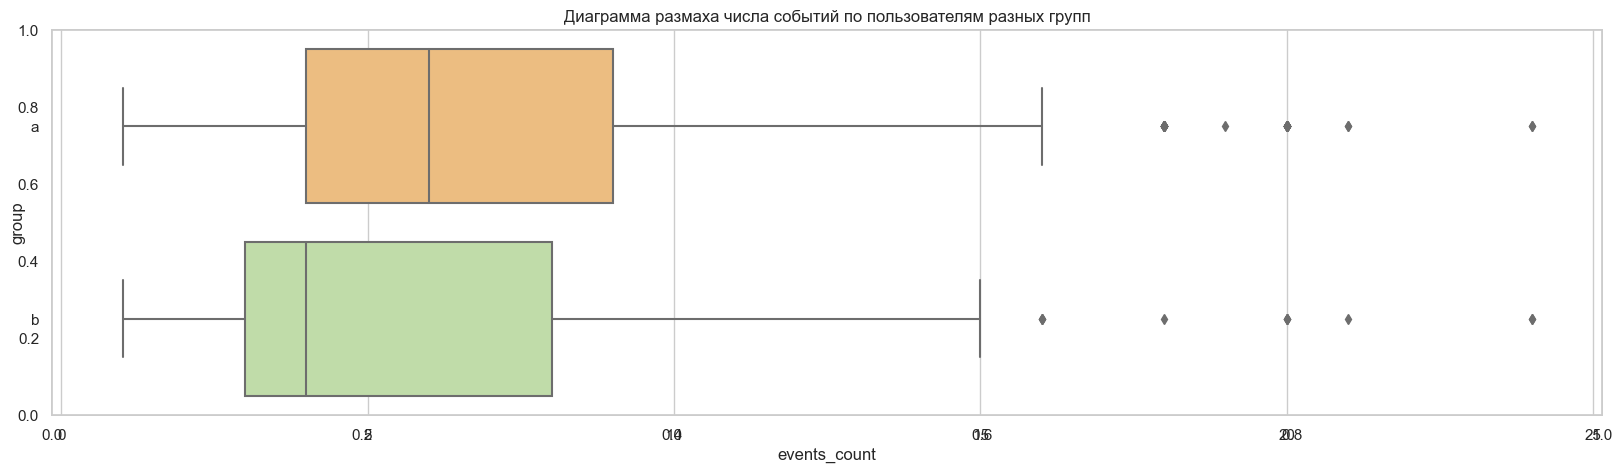

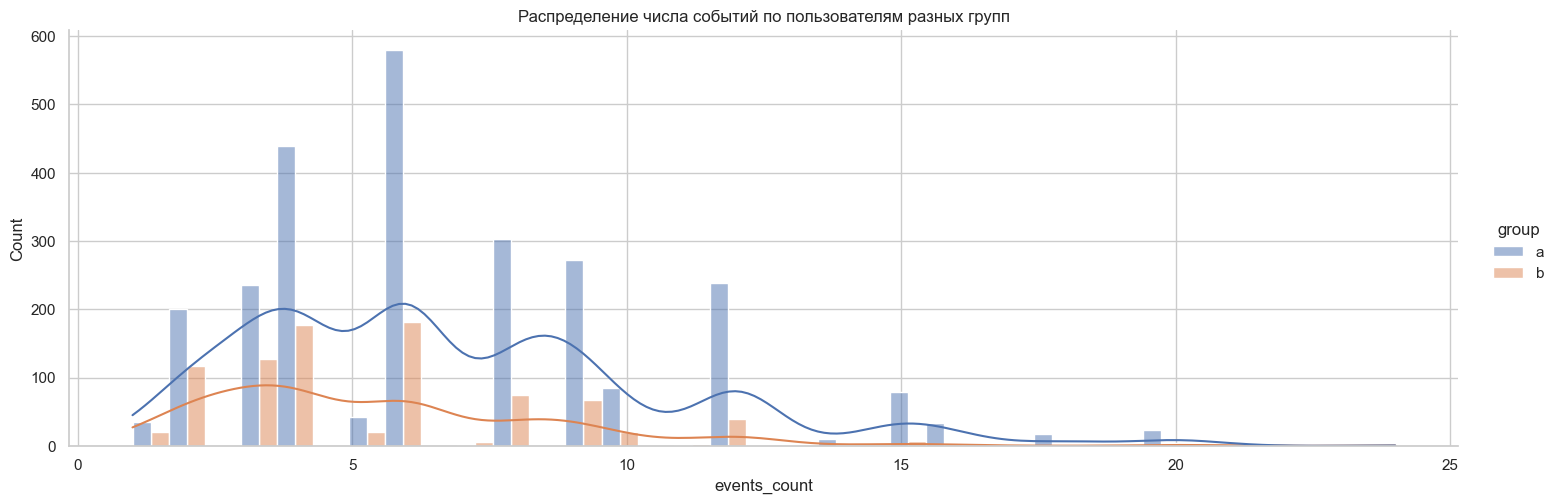

In [39]:
group_user_grp = final_ab.groupby(['group', 'user_id']).agg(events_count=('event_name', 'count')).reset_index()

fig = plt.figure(figsize=(20, 5))

ax_1 = fig.add_subplot(1, 1, 1)
ax_2 = fig.add_subplot(1, 1, 1)

sns.displot(data=group_user_grp, x='events_count', kde=True, hue='group', multiple='dodge', aspect=3, ax=ax_1)\
    .set(title='Распределение числа событий по пользователям разных групп')
sns.boxplot(data=group_user_grp, x='events_count', y='group', palette='Spectral', orient='h', ax=ax_2)\
    .set(title='Диаграмма размаха числа событий по пользователям разных групп')

plt.show()

In [40]:
# числовое описание количества событий для пользователя
group_user_grp.groupby('group').describe()

events_count                                    
             count mean  std  min  25%  50%  75%   max
group                                                 
a         2,604.00 6.90 3.84 1.00 4.00 6.00 9.00 24.00
b           877.00 5.53 3.31 1.00 3.00 4.00 8.00 24.00

**Вывод:**


### Распределение событий по дням

In [41]:
# Для дальнейшего анализа добавлю колонку с датой на основе столбца event_dt
final_ab['event_date'] = final_ab['event_dt'].dt.date
final_ab.head(2)

,user_id,group,ab_test,region,device,event_name,details,first_date,event_dt,lifetime,event_date
0,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,purchase,99.99,2020-12-07,2020-12-07 14:43:27,0,2020-12-07
1,d1aba3e2887b6a73,a,recommender_system_test,eu,pc,product_cart,0.00,2020-12-07,2020-12-07 14:43:29,0,2020-12-07


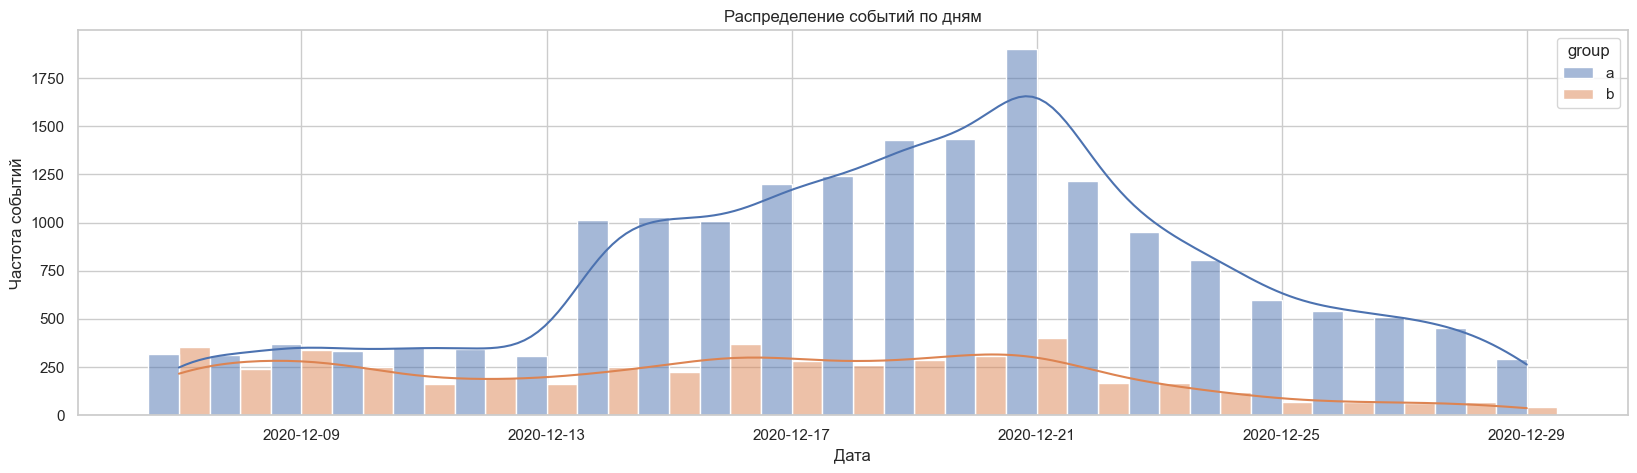

In [42]:
plt.subplots(figsize=(20, 5))
sns.histplot(data=final_ab, x=final_ab['event_date'], 
             hue='group', multiple='dodge',
             kde=True).set_title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Частота событий')
plt.show()

На основании гистограммы распределения отмечу:

- в первые дни количество событий по группам было примерно одинаковым, до 13 числа разница в числе событий для групп была не так велика, затем для группы А резко увеличилось число событий - в 3-5 раз.
- для группы А после 14 числа пошел резкий рост числа событий с пиком 21 числа
- для группы В события распределены равномерно

Так как группы несбалансированны по количеству участников, посмотрю на распределение среднего количества событий в день на пользователя.

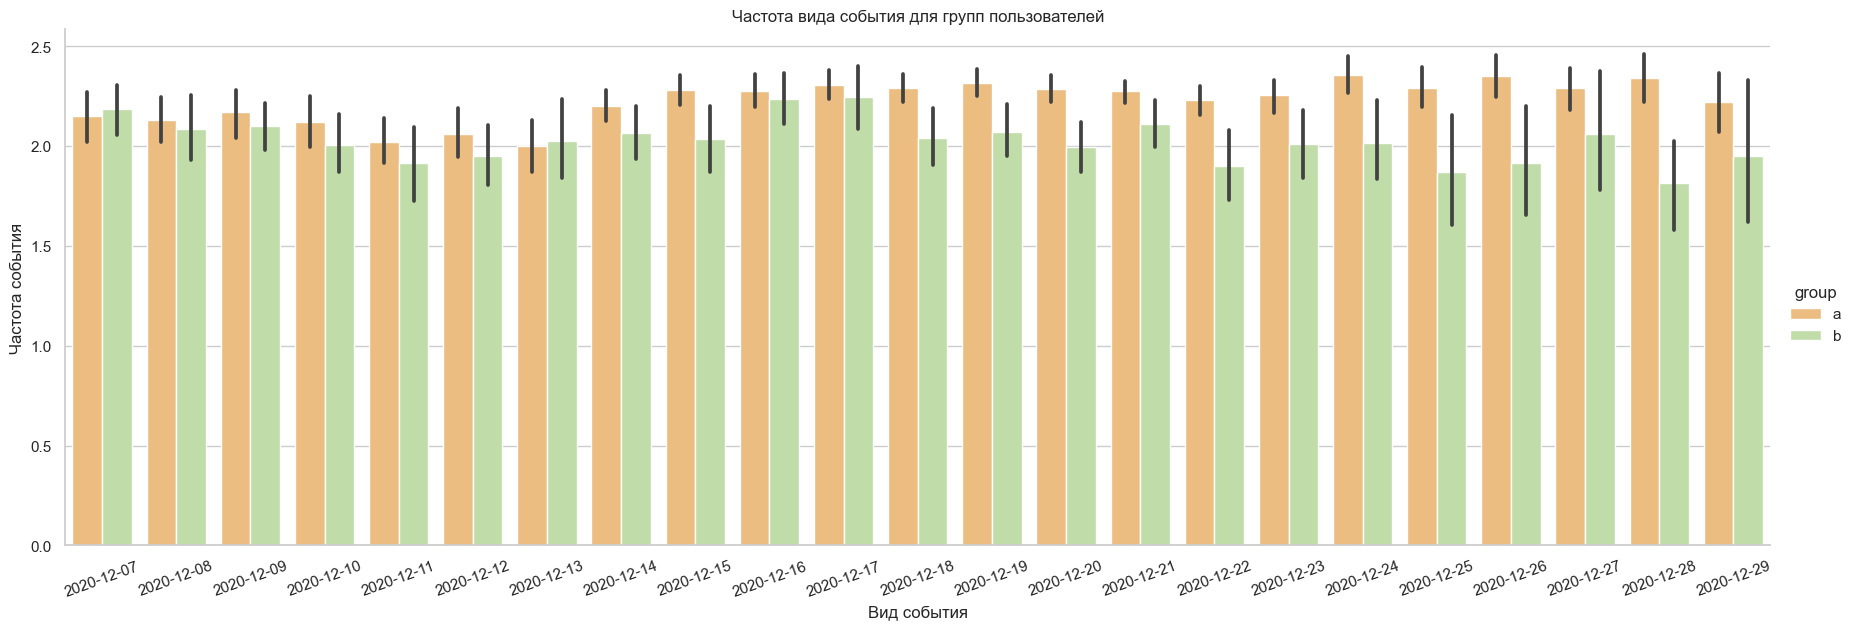

In [43]:
group_user_date_grp = (final_ab.groupby(['event_date', 'group', 'user_id'])
                        .agg(events_count=('event_date', 'count')).reset_index()).sort_values(by=['event_date', 'group'])

# Количество каждого события для пользователей разных групп
sns.catplot(data=group_user_date_grp, x='event_date', y='events_count', 
            kind='bar', hue='group', palette='Spectral', height=6, aspect=3)

plt.title('Частота вида события для групп пользователей')
plt.xlabel('Вид события')
plt.ylabel('Частота события')
plt.xticks(rotation=20)
plt.show()

После 13 декабря заметно увеличение числа событий для пользователя из группы А по сравнению с группой В.


### Конверсия в воронке событий

Как меняется конверсия в воронке в выборках на разных этапах?

События:

1. login - вход в приложение,
2. product_page - просмотр карточек товаров,
3. product_cart - просмотры корзины,
4. purchase - покупки

Построю воронку событий для пользователей из разных групп теста.

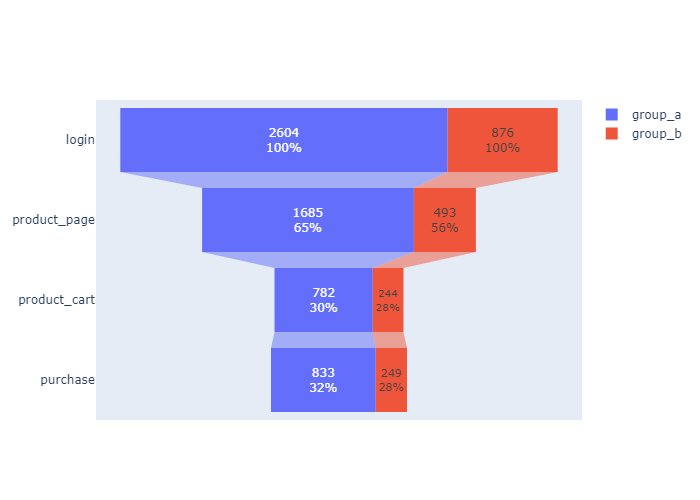

In [49]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group_a',
    y = final_event_pvt['event_name'],
    x = final_event_pvt['a'],
    textinfo = 'value+percent initial'))

fig.add_trace(go.Funnel(
    name = 'group_b',
    y = final_event_pvt['event_name'],
    x = final_event_pvt['b'],
    textposition = 'inside',
    textinfo = 'value+percent initial'))

#Визуализация plotly в GitHub
fig.show('png')

- Исходя из воронки и количества покупок, можем сделать вывод что у приложения есть функция покупки в один клик, без перехода в корзину. Это объясняет почему на последнем этапе воронки количество пользователей больше чем на предыдущем.
- Больше всего пользователей теряется на 3 шаге, то есть после просмотра карточки товара при переходе в корзину товара / оплате.
- Конверсия для группы А выше чем для группы В, на всех этапах кроме перехода от просмотра карточки к просмотру корзины(здесь на 3% меньше)

### Особенности данных

Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Прежде чем приступать к A/B-тестированию необходимо учесть:

1. Дата завершения тестирования отличается от требования в ТЗ. События, происходившие с 23:36:33 30 декабря до 4 января не попали в датасет.

    Дата 4 января была выбрана исходя двухнедельного горизонта анализа (регистрация пользователй заканчивалась 21 декабря). Но данные зашли за период короче на 5 дней. Таким образом, мы не досчитаемся событий пользователей при проверке улучшения конверсии - в анализ не попадут события тех кто присоединился позже 16 декабря.

2. Дата набора новых пользователей. В датасете были пользователи с датой регистрации 23.12.2020, что на 2 дня позже требования ТЗ, пользователи с регистрацией после 21.12 были исключены из анализа.

3. Общее число пользователей не соответствует ТЗ - 3 481 чел. вместо 6 000 из-за того, что присутствуют пользователи, не совершившие действия.

4. Присутствует достаточно большое число пользователей (1 602 чел.), участвующих в двух тестах одновременно, ТЗ на второй тест мы не знаем и нет возможности полностью установить как это повлияет на текущее исследование.

5. Число участников в группах А и В сильно отличается (2604 и 877 соответственно)

**Вывод - Исследовательский анализ данных:**

1. Пользователи обеих групп в среднем совершают сопостовимое число действий (6.9 для группы А и 5.5 для группы В). Однако из-за того, что пользователей в группе А больше, то валово число действий в этой группе превышает действия группы В.
2. Число событий можно разбить на 3 временных отрезка:
    - период 07.12-13.12 - небольшое число событий
    - период 14.12-23.12 - наибольшее число событий с пиком 21 декабря
    - период 24.12-30.12 - умеренное число событий с трндом на снижение
3. Конверсия для группы А выше чем для группы В, на всех этапах кроме перехода от просмотра карточки к просмотру корзины.

[Оглавление](#section_id)

## Оцените результаты A/B-тестирования
<a id='section_id4'></a>

    - Что можно сказать про результаты A/В-тестирования?
    - Проверьте статистическую разницу долей z-критерием.
    
### Что можно сказать про результаты A/В-тестирования?

Как было отмечено ранее, число фактических пользователей существенно ниже ожидаемого, таким образом, статистическая мощность тестирования будет невысокой.

### Статистическая разница долей, z-критерий

Чтобы определить, есть ли статистически значимая разница между группами A и B, проверю гипотезы на равенство долей пользователей совершивших событие.

In [45]:
# Соберу датафреймы для проверки статистических разниц событий:
group_event_pvt = final_ab.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
# Уберу событие login, т.к. для него не получится посчитать success и trials будут равны
group_event_pvt = group_event_pvt[1:]

user_count = final_ab.groupby('group')['user_id'].nunique().reset_index()
user_count.set_index('group', inplace=True)
# Выведу два датафрейма:
display(group_event_pvt)
user_count

group,a,b
event_name,,
product_cart,782,244
product_page,1685,493
purchase,833,249


,user_id
group,
a,2604
b,877


In [46]:
# Использую Z-критерий и напишу функцию для всех событий
def z_test(event, alpha):
    # Переменные для упрощения дальнейшего кода:
    successes_1 = group_event_pvt.loc[event, 'a']
    successes_2 = group_event_pvt.loc[event, 'b']
    trials_1 = user_count.loc['a', 'user_id']
    trials_2 = user_count.loc['b', 'user_id']
    
    # пропорции успехов по 2ум группам:
    p1 = successes_1 / trials_1
    p2 = successes_2 / trials_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    # разница пропорций в датасетах:
    difference = p1 - p2
    # считаюю статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials_1 + 1 / trials_2))
    # задаю стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для групп a и b, событие: {}, p-значение: {p_value}'.format(event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть статистическая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: между группами нет статистической разницы")

Сформулирую гипотезы

- H0: доли уникальных посетителей, побывавших на этапе воронки, **одинаковы**.
- H1: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая **разница**.

Уровень значимости установлю в 0.05.

In [47]:
for event in group_event_pvt.index:
    z_test(event, 0.05)
    print()

Проверка для групп a и b, событие: product_cart, p-значение: 0.21469192029582396
Не получилось отвергнуть нулевую гипотезу: между группами нет статистической разницы

Проверка для групп a и b, событие: product_page, p-значение: 6.942739359416805e-06
Отвергаем нулевую гипотезу: между группами есть статистическая разница

Проверка для групп a и b, событие: purchase, p-значение: 0.04652482738393027
Отвергаем нулевую гипотезу: между группами есть статистическая разница



**Вывод:**

- Для события `product_cart` нет статистически значимой разницы в количестве пользователей между группами теста.
- Для событий `product_page` и `purchase` есть статистически значимая разница между пользователями групп.

Но отдельно хочу ещё раз отметить, что число пользователей для теста примерно в 2 раза ниже требуемого, таким образом, есть вероятность получения ложного результата.

[Оглавление](#section_id)

## Результат исследования
<a id='section_id5'></a>

**Описание данных**

Для проведения исследования использовался набор из 4 датасетов с пользовательскими действиями (база пользователей, дата регистрации, совершённые действия, а также календарь маркетинговых мероприятий компании).

**Предобработка данных**

На этапе предобработки выполнены следующие шаги:

- Все буквенные значения в датасетах приведены к нижнему регистру.
- Данные приведены к нужному типу
- Явные дубликаты не обнаружены
- Пропуски в final_ab_events проанализирваны, замены на нули.

**Корректность проведения теста**

1. Данные проверены на соответствие ТЗ. Выявлены отклонения от требований:
    - дата остановки тестирования, ожидаемая - 04.01, фактическая - 30.12
    - число пользователей ниже ожидаемых 6 000 - по факту число активных пользователей 3 481
    - пользователи за 14 дней с момента регистрации не показали улучшение конверсий в события на 10%, наоборот наблюдается ухудшение эти показателей.
2. Время тестирования приходится на маркетинговую кампанию `christmas&new year promo`, однако по результатам анализа, влияния на действия пользователей двух групп не выявлено.
3. Присутствуют большое число пользователей (1 602 чел.), участвующих в двух тестах одновременно, ТЗ на второй тест мы не знаем и нет возможности полностью установить влияние второго теста на наше исследование.


**Исследовательский анализ данных - EDA**

1. Пользователи обеих групп в среднем совершают сопостовимое число действий (7 для группы А и 5.8 для группы В). Однако из-за того, что пользователей в группе А больше, то валово число действий в этой группе превышает действия группы В.
2. Число событий можно разбить на 3 временных отрезка:
    - период 07.12-13.12 - небольшое число событий
    - период 14.12-23.12 - наибольшее число событий с пиком 21 декабря
    - период 24.12-30.12 - умеренное число событий с трндом на снижение
3. Конверсия для группы А выше чем для группы В, на всех этапах кроме перехода от просмотра карточки к просмотру корзины.

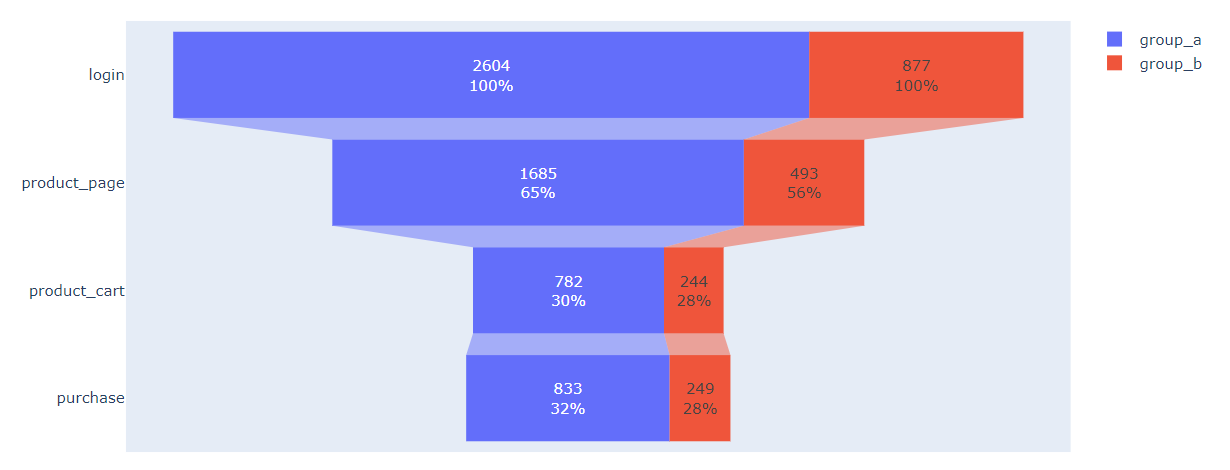

### Результаты A/B-тестирования

По резульату A/B тестирования были проверены гипотезы на равенство долей пользователей совершивших событие.

- H0: доли уникальных посетителей, побывавших на этапе воронки, **одинаковы**.
- H1: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая **разница**.

In [48]:
for event in group_event_pvt.index:
    z_test(event, 0.05)
    print()

Проверка для групп a и b, событие: product_cart, p-значение: 0.21469192029582396
Не получилось отвергнуть нулевую гипотезу: между группами нет статистической разницы

Проверка для групп a и b, событие: product_page, p-значение: 6.942739359416805e-06
Отвергаем нулевую гипотезу: между группами есть статистическая разница

Проверка для групп a и b, событие: purchase, p-значение: 0.04652482738393027
Отвергаем нулевую гипотезу: между группами есть статистическая разница



**Вывод:**

- Для события `product_cart` нет статистически значимой разницы в количестве пользователей между группами теста.
- Для событий `product_page` и `purchase` есть статистически значимая разница между пользователями групп.


### Общий вывод исследования

Результаты статистической проверки позволяют нам сказать, что новая рекомендательная система не показала должных изменений и следует признать тест неудачным. Но нужно учитывать низкую мощность статистического теста, таким образом, вероятность ошибиться из-за относительно низкого числа пользователей, велика.